**Import**

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model
import time
import matplotlib.pyplot as plt

**Load DataSet**

In [ ]:
# Load MNIST Dataset
dataset, info = tfds.load('mnist', as_supervised = True, with_info = True)
dataset_test, dataset_train = dataset['test'], dataset['train']

#Convert
def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 128

dataset_train = dataset_train.map(convert_types).shuffle(10000).batch(batch_size)
dataset_test = dataset_test.map(convert_types).batch(batch_size)
#Data Augmentation
datagen = ImageDataGenerator(rotation_range = 10, horizontal_flip = True, zoom_range = 0.1)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


**ResNet50 Model**

In [ ]:
# Residual Block
class ResidualBlock(Model):
    def __init__(self, channel_in = 64, channel_out = 256):
        super().__init__()
      
        channel = channel_out // 4
        # Batch Normalization after Convolution layer
        self.conv1 = Conv2D(channel, kernel_size = (1, 1), padding = "same")
        self.bn1 = BatchNormalization()
        self.av1 = Activation(tf.nn.relu)
        self.conv2 = Conv2D(channel, kernel_size = (3, 3), padding = "same")
        self.bn2 = BatchNormalization()
        self.av2 = Activation(tf.nn.relu)
        self.conv3 = Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
        self.bn3 = BatchNormalization()
        self.shortcut = self._shortcut(channel_in, channel_out)
        self.add = Add()
        self.av3 = Activation(tf.nn.relu)
        
    def call(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.av1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.av2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        h = self.add([h, shortcut])
        y = self.av3(h)
        return y
    
    # Shortcut
    def _shortcut(self, channel_in, channel_out):
        if channel_in == channel_out:
            return lambda x : x
        else:
            return self._projection(channel_out)
        
    def _projection(self, channel_out):
        return Conv2D(channel_out, kernel_size = (1, 1), padding = "same")

# ResNet           
class ResNet50(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()                
        
        self._layers = [
            # convolution Layer 1 (conv1)
            Conv2D(64, input_shape = input_shape, kernel_size = (7, 7), strides=(2, 2), padding = "same"),
            BatchNormalization(),
            Activation(tf.nn.relu),
            # convolution Layer 2 (conv2_x)
            MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same"),
            ResidualBlock(64, 256),
            [
                ResidualBlock(256, 256) for _ in range(2)                
            ],
            # convolution Layer 3 (conv3_x)
            Conv2D(512, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(512, 512) for _ in range(4)                
            ],
            # convolution Layer 4 (conv4_x)
            Conv2D(1024, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(1024, 1024) for _ in range(6)                
            ],
            # convolution Layer 5 (conv5_x)
            Conv2D(2048, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(2048, 2048) for _ in range(3)
            ],
            # Average Pooling and FC1000 layer
            GlobalAveragePooling2D(),
            Dense(1000, activation = tf.nn.relu),
            Dense(output_dim, activation = tf.nn.softmax)
        ]
        
    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)    
            else:
                x = layer(x)
        return x
       
model = ResNet50((28, 28, 1), 10)
model.build(input_shape = (None, 28, 28, 1))
model.summary()

Model: "res_net50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 residual_block (ResidualBlo  multiple                 75904     
 ck)                                                             
                                                         

**Loss and OPtimizer**

In [ ]:
# Categorial CrossEntropy
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
# Adam
optimizer = tf.keras.optimizers.Adam()

**Pre-Training**

In [ ]:
# Train Loss and Accuracy
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')
# Test Loss and Accuracy
test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')


@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = model(image)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(label, predictions)
        
@tf.function
def test_step(image, label):
    predictions = model(image)
    loss = loss_object(label, predictions)
    
    test_loss(loss)
    test_accuracy(label, predictions)


**Training**

In [ ]:
num_epoch = 50
start_time = time.time()

train_accuracies = []
test_accuracies = []

for epoch in range(num_epoch):    
    for image, label in dataset_train:
        for _image, _label in datagen.flow(image, label, batch_size = batch_size):
            train_step(_image, _label)
            break
        
    for test_image, test_label in dataset_test:
        test_step(test_image, test_label)
        
    train_accuracies.append(train_accuracy.result())
    test_accuracies.append(test_accuracy.result())    
    
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, spent_time: {} min'
    spent_time = time.time() - start_time
    print(template.format(epoch + 1, train_loss.result(), train_accuracy.result() * 100, test_loss.result(), test_accuracy.result() * 100, spent_time / 60))


Epoch 1, Loss: 0.707275390625, Accuracy: 75.02999877929688, Test Loss: 0.17129579186439514, Test Accuracy: 94.52999877929688, spent_time: 1.627074619134267 min
Epoch 2, Loss: 0.43897369503974915, Accuracy: 85.0808334350586, Test Loss: 0.12706804275512695, Test Accuracy: 95.93000030517578, spent_time: 2.7926600853602093 min
Epoch 3, Loss: 0.3349558413028717, Accuracy: 88.87222290039062, Test Loss: 0.11373429000377655, Test Accuracy: 96.42333221435547, spent_time: 3.959008502960205 min
Epoch 4, Loss: 0.2794094979763031, Accuracy: 90.85542297363281, Test Loss: 0.10661181062459946, Test Accuracy: 96.68000030517578, spent_time: 5.1250954389572145 min
Epoch 5, Loss: 0.244023397564888, Accuracy: 92.10733032226562, Test Loss: 0.09673690050840378, Test Accuracy: 97.01799774169922, spent_time: 6.293505314985911 min
Epoch 6, Loss: 0.21786178648471832, Accuracy: 93.01666259765625, Test Loss: 0.09834827482700348, Test Accuracy: 96.97000122070312, spent_time: 7.50565292040507 min
Epoch 7, Loss: 0.19

**Plot**

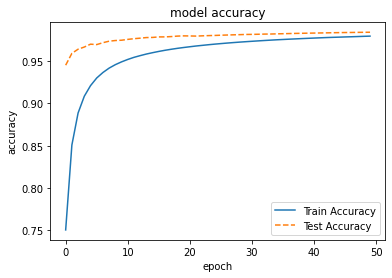

In [ ]:
plt.plot(train_accuracies, label = 'Train Accuracy')
plt.plot(test_accuracies, linestyle = 'dashed', label = 'Test Accuracy')
plt.title('model accuracy'); plt.ylabel('accuracy'); plt.xlabel('epoch'); 
plt.legend()
plt.show()